# GCN for Jet tagging using jet constituents from HLS data
## Author: Andre Sznajder

In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'


# Load HLS4ML dataset 

## Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

## https://github.com/pierinim/tutorials/blob/master/GGI_Jan2021/Lecture1/Notebook1_ExploreDataset.ipynb

 * 'jetImage' contains the image representation of the jets (more later)

 * 'jetImageECAL' and 'jetImageHCAL' are the ECAL- and HCAL-only equivalent images. We will not use them (but you are more than welcome to play with it)

 * 'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored

 * 'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList' 'jets' is the dataset we consider for the moment

 * 'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'


In [3]:
import numpy as np
import h5py
import os

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']



#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/data/hls4ml_LHCjet_150p_train/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])

first=True
for file in os.listdir(TRAIN_PATH):
  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1] 
    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )


'''
# for fileIN in glob.glob(data_dir+"*h5"):
first=1
target = np.array([])
jetConstituent = np.array([])
jetImage = np.array([])

for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(fileIN)
    if (first):
        first=0
        print("Keys in H5PY files = ",list( f.keys() ))
        print(" ")
        featurenames = f.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = f.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = f.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")
 
    # for pT, eta, phi
    #myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
    # for px, py, pz
    #myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#    myJetConstituentList = np.array(f.get("jetConstituentList"))

    # for pT, eta, phi
    myJetConstituent = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    myimage  = np.array(f.get('jetImage'))
    jetConstituent = np.concatenate([jetConstituent, myJetConstituent], axis=0) if jetConstituent.size else myJetConstituent
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    jetImage = np.concatenate([jetImage, myimage], axis=0) if jetImage.size else myimage
    del myJetConstituent, mytarget , myimage
    f.close()
'''
                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
#print("Jet Image shape =", jetImage.shape)


Target shape = (620000, 5)
Jet Constituents shape = (620000, 150, 3)


# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [4]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Restric the number of constituents to a maximum of NMAX
nmax = 32
jetConstituent = jetConstituent[:,0:nmax,:]
nconstit = jetConstituent.shape[1]
print('------>>>> New Max Number of constituents =',nconstit)

# Flatten the 2D ( eta x phi ) jet image into 1D array to input into a MLP 
#jetImage = rearrange( jetImage , 'batch eta phi -> batch (eta phi)' )  
#print('Shape of flattened jetImage=',jetImage.shape)


Number of jets = 620000
Number of constituents = 150
Number of features = 3
------>>>> New Max Number of constituents = 32


## Create the Adjacency Matrix for each Jet Image

In [5]:
from sklearn.neighbors import kneighbors_graph
import math

# Create Graphs from jet images with the following format
#
#  Adjacent matrix:  A[batch_size, num_nodes, num_nodes] (should be normalized in advance)
#  Features matrix:  X[batch_size, num_nodes, num_features]
#       

'''
M = np.array([])
for x in np.arange(0,dim):
    result = np.array([])

    for y in np.arange(0,dim):
        result_temp = sum(arr1[arr2 == x] == y)
        result = np.append(result, result_temp)

    M = np.append(M,result) 
'''

# Loop over jets to create a Graph Adjacency
A = []
X = []
Y = []
ng = 0

# Loop over jets
for constit in jetConstituent: 
   
    # Check if reached max # of requested graphs 
#    if (ng > ngmax): break
    ng += 1

    # Create an Adjacency matrix using KNN algorithm
    k=4

#    adj = kneighbors_graph(constit, k, mode="distance")
    adj = kneighbors_graph(constit, k)
    
    '''    
    # Define Edge freatures from adjacency matrix A
    n = len(constit)
    E = np.zeros((n,n))
    for index, x in np.ndenumerate(adj.toarray()):
        if x==0.0 : continue
        i=index[0]
        j=index[1]
        deta = constit[i,0] - constit[j,0]
        dphi = constit[i,1] - constit[j,1]
        dpt  = constit[i,2] - constit[j,2]
        # Define the edge weight as distance in EtaxPhi
        etamax = max(abs(constit[i,0]),abs(constit[j,0]))
        phimax = max(abs(constit[i,1]),abs(constit[j,1]))
        if ( etamax==0.0 or phimax==0.0 ) : 
            dr=999999.
        else: 
            dr=((deta/etamax)**2+(dphi/phimax)**2)  # BEST PERFORMING METRIC !!!
#            dr=math.sqrt(deta**2+dphi**2)  # 

        E[i,j] = math.exp(-dr)
#        E[i,j]=1/dr
    '''

# Append Adjacency matrix and Feature vector to list    
    A.append(adj)
#    A.append(E)
    X.append(constit)


# Define GRAPH tensors for the full dataset in BATCH MODE ( https://graphneural.network/data-modes )
# The tensor dimensions corresponds to the maximum graph size (max # nodes) x (# features)
ngraphs = len(jetConstituent) # Number of graphs ( number of jets )
ntargets = 5

XX = np.zeros((ngraphs, nconstit, nfeat) , dtype=np.float32) # node features 
AA = np.zeros((ngraphs, nconstit, nconstit ) , dtype=np.float32)  # adjacency matrix
YY = np.zeros((ngraphs, ntargets) , dtype=np.float32)             # target label


# Loop over graphs to fill the input tensors ( with event # indexed by i ) 
for i in range(ngraphs):
  n_nodes = len(X[i])
  XX[i, 0:nconstit, 0:nfeat] = X[i] 
  AA[i, 0:nconstit, 0:nconstit] = A[i].todense()
#  AA[i, 0:n_nodes, 0:n_nodes] = A[i]
  YY[i, 0:ntargets] = target[i]
    
del jetConstituent, target


print("AA Shape = ",AA.shape)
print("XX Shape = ",XX.shape)
print("YY Shape = ",YY.shape)

print("AA Shape[0] = ",AA.shape[0])
print("AA Shape[1] = ",AA.shape[1])
print("AA Shape[2] = ",AA.shape[2])

print("XX Shape[0] = ",XX.shape[0])
print("XX Shape[1] = ",XX.shape[1])
print("XX Shape[2] = ",XX.shape[2])


AA Shape =  (620000, 32, 32)
XX Shape =  (620000, 32, 3)
YY Shape =  (620000, 5)
AA Shape[0] =  620000
AA Shape[1] =  32
AA Shape[2] =  32
XX Shape[0] =  620000
XX Shape[1] =  32
XX Shape[2] =  3


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [6]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, A_train_val, A_test, Y_train_val, Y_test = train_test_split(XX, AA, YY, test_size=0.33, random_state=7)

#print(X_train_val.shape, X_test.shape, A_train_val.shape, A_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of B jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))


print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of B jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))





number of G jets for training/validation: 83689
number of Q jets for training/validation: 80676
number of W jets for training/validation: 83507
number of B jets for training/validation: 83589
number of T jets for training/validation: 83939
number of G jets for testing: 41159
number of Q jets for testing: 39535
number of W jets for testing: 41430
number of B jets for testing: 41065
number of T jets for testing: 41411


## Define GCN Layer


In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras.layers import Layer

##########################################################################
#
# Customized GCNConv Layer modified from SPEKTRAL package
# https://github.com/danielegrattarola/spektral/blob/master/spektral/layers/convolutional/gcn_conv.py
# https://github.com/danielegrattarola/spektral/blob/master/spektral/layers/convolutional/gcs_conv.py
#
#########################################################################
#
class GCNConv(Layer):
    """
    Graph Convolutional Layer with trainable skip connection ( more expressive that Kipf GCN as it 
         has flexibility for learning edge features ( AXW1 + XW2 ) )
    """

    def __init__( self, channels, activation=None, **kwargs ):
        super().__init__( GCNConv, **kwargs )
        self.channels = channels
        self.activation = activations.get(activation) 

    def build(self, input_shape):
        assert len(input_shape) >= 2
#        input_dim = input_shape[0][-1]
        input_dim = input_shape[1][-1]
        self.wgt = self.add_weight(
            shape=(input_dim, self.channels),
            name="wgt"
        )
        self.bias = self.add_weight(
            shape=(self.channels,),
            name="bias"
        )

    def call(self, inputs):
        a, x = inputs

#        print("shape a=",a.shape)
#        print("shape x=",x.shape)        
#        print("shape w=",self.wgt.shape)
        
#        output = ops.modal_dot(a, output)
#        output = K.dot(a, output)
#        awx = K.dot(a, wx)
        # Add identity to adjacency to create Â=A+I and take into account self-loop
        ahat = a + np.identity(a.shape[1])
        xw = K.dot(x, self.wgt)  
        axw = tf.matmul(ahat, xw)
        z = K.bias_add(axw, self.bias) 
        output = self.activation(z)
        return output


    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(GCNConv, self).get_config()
        config = {"channels": self.channels,
                  "activation":self.activation}
        return dict(list(base_config.items()) + list(config.items()))


In [8]:
# baseline keras model
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten , BatchNormalization, MaxPool1D
from tensorflow.keras import utils

# Define GCN network 

# Instantiate Tensorflow input tensors in Batch mode 
X = Input(shape=(nconstit, nfeat), name="X")
A = Input(shape=(nconstit, nconstit), sparse=False, name="A") 

print("X type=",type(X))
print("A type=",type(A))
print("X shape=",X.shape)
print("A shape=",A.shape)


# GCN Model  ( sem Maxpool )
H = BatchNormalization(momentum=0.1,name='batchnorm_1')(X)
H = GCNConv(channels=nfeat*8, activation="relu")([A,H])
H = GCNConv(channels=nfeat*4, activation="relu")([A,H])
H = Flatten()(H)
H = Dense(int(nconstit*nfeat/8), activation="relu")(H)

'''
# GCN Model ( com Maxpool )
H = BatchNormalization(momentum=0.1,name='batchnorm_1')(X)
H = GCNConv(channels=nfeat*8, activation="relu")([A,H])
H = GCNConv(channels=nfeat*4, activation="relu")([A,H])
#H = MaxPool1D(pool_size=8, strides=4, padding='valid', name='maxpool1d_1')(H)
H = MaxPool1D(pool_size=6, strides=3, padding='valid', name='maxpool1d_1')(H)
H = Flatten()(H)
H = Dense(int(nconstit*nfeat/2), activation="relu")(H)
'''
O = Dense(ntargets, activation="softmax") (H)

# Build the GCN model
model = Model(inputs=[A,X], outputs=O)

# Define the optimizer ( minimization algorithm )
#optim = SGD(lr=0.0001,decay=1e-6)
optim = Adam(lr=0.0005)
#optim = Nadam(lr=0.0005)

# Compile the Model
#model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()


X type= <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
A type= <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
X shape= (None, 32, 3)
A shape= (None, 32, 32)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to              

## Run training
Here, we run the training.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=5)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('mlp_model.h5', monitor='categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
history = model.fit(  [A_train_val, X_train_val] , Y_train_val, 
                    epochs=50, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
                    

Epoch 1/50
568/568 [==============================] - 7s 11ms/step - loss: 1.8325 - categorical_accuracy: 0.2835 - val_loss: 1.3342 - val_categorical_accuracy: 0.4400
Epoch 2/50
568/568 [==============================] - 5s 10ms/step - loss: 1.2899 - categorical_accuracy: 0.4637 - val_loss: 1.2046 - val_categorical_accuracy: 0.4991
Epoch 3/50
568/568 [==============================] - 6s 10ms/step - loss: 1.1864 - categorical_accuracy: 0.5069 - val_loss: 1.1633 - val_categorical_accuracy: 0.5209
Epoch 4/50
568/568 [==============================] - 6s 10ms/step - loss: 1.1459 - categorical_accuracy: 0.5252 - val_loss: 1.1289 - val_categorical_accuracy: 0.5333
Epoch 5/50
568/568 [==============================] - 5s 10ms/step - loss: 1.1242 - categorical_accuracy: 0.5330 - val_loss: 1.1104 - val_categorical_accuracy: 0.5408
Epoch 6/50
568/568 [==============================] - 5s 10ms/step - loss: 1.1070 - categorical_accuracy: 0.5420 - val_loss: 1.1135 - val_categorical_accuracy: 0.539

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

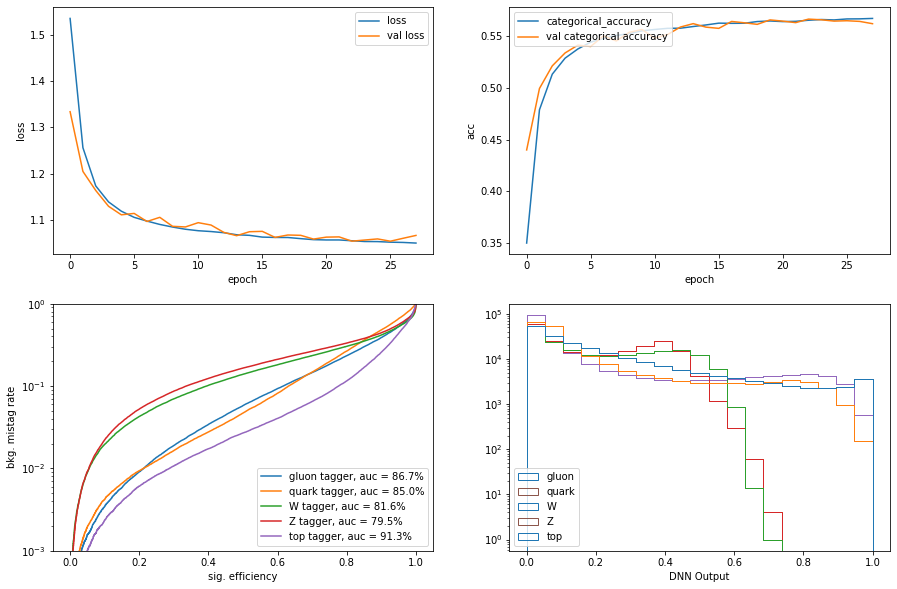

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

'''
# Plot ROC
Y_predict = mlp.predict([A_test,X_test])
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
ax = plt.subplot(2, 2, 3)
ax.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('false positive rate')
ax.set_ylabel('true positive rate')
ax.set_title('receiver operating curve')
ax.legend(loc="lower right")
'''

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
ax = plt.subplot(2, 2, 3)
Y_predict = model.predict([A_test,X_test])
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
# Display plots
plt.show()
